In [ ]:
# default_exp misc_splitters

In [ ]:
#hide
#ci
!pip install -Uqq fastai --upgrade

In [ ]:
#hide
#local
%cd ..
# from my_timesaver_utils.profiling import *
%cd nbs

# Misc Splitters

> splitters for reducing dataset sizes

In [ ]:
#hide
#local
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
# from my_timesaver_utils.profiling import *

In [ ]:
#export
import warnings
FASTAI_AVAILABLE = True
try:
    from fastcore.foundation import L
except ImportError as e:
    FASTAI_AVAILABLE = False
    warnings.warn('fastai package not installed, callback simulated')

In [ ]:
#export
if not FASTAI_AVAILABLE:
    def L(*args,**kwargs):
        return list(*args)

In [ ]:
#export
def DumbFixedSplitter(train_pct):
    'A splitter that takes the 1st `train_pct` as the train elements'
    assert 0 < train_pct < 1
    def _inner(o):
        o_len = len(o)
        train_len = int(o_len*train_pct)
        idxs = L(list(range(o_len)))
        return idxs[:train_len], idxs[train_len:]
    return _inner 

In [ ]:
#export

def SubsetPercentageSplitter(main_splitter, train_pct=0.5, valid_pct=None, randomize=False, seed=None):
    "Take fixed pct of `splits` with `train_pct` and `valid_pct` from main splitter"
    assert main_splitter is not None
    assert 0 <= train_pct <= 1
    valid_pct = train_pct if valid_pct is None else valid_pct
    assert 0 <= valid_pct <= 1
    if randomize:
        if seed is not None:
            rng = random.Random(seed)
        else:
            rng = random.Random(random.randint(0,2**32-1))

    def _inner(o):
        train_idxs, valid_idxs = main_splitter(o)
        train_len = int(len(train_idxs)*train_pct)
        valid_len = int(len(valid_idxs)*valid_pct)
        if randomize:
            train_idxs = rng.sample(train_idxs, train_len)
            valid_idxs = rng.sample(valid_idxs, valid_len)
        return train_idxs[:train_len],valid_idxs[:valid_len]
    return _inner


### Example Usage

In [ ]:
from fastai.vision.all import *

In [ ]:
mlist = list(range(20)); mlist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
df_splitter = DumbFixedSplitter(0.8)

In [ ]:
t1_train, t2_valid = df_splitter(mlist); t1_train

(#16) [0,1,2,3,4,5,6,7,8,9...]

In [ ]:
t2_valid

(#4) [16,17,18,19]

In [ ]:
fs_splitter = SubsetPercentageSplitter(df_splitter, randomize=True, seed=42)

In [ ]:
ft1_train, ft2_valid = fs_splitter(mlist)

In [ ]:
ft1_train

[3, 0, 11, 4, 15, 13, 2, 1]

In [ ]:
ft2_valid

[16, 18]

In [ ]:
path = untar_data(URLs.MNIST_TINY)

In [ ]:
data = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=SubsetPercentageSplitter(
        GrandparentSplitter(),
        train_pct=0.02,randomize=True, seed=42
    ),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
data.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 14,13
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/butch/.fastai/data/mnist_tiny/train/3/8976.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/butch/.fastai/data/mnist_tiny/train/3/8976.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(0))


Found 1428 items
2 datasets of sizes 14,13
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Res

In [ ]:
dls = data.dataloaders(path, bs=4)

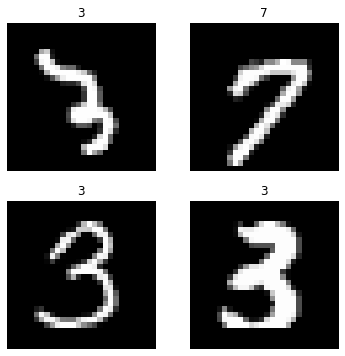

In [ ]:
dls.show_batch()

In [ ]:
dls.c

2

In [ ]:
len(dls.train), len(dls.valid)

(3, 4)

In [ ]:
len(dls.train.items)

14

In [ ]:
len(dls.valid.items)

13

In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
learner.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.237793,0.674581,0.692308,00:01
1,1.195532,0.639463,0.692308,00:00
2,1.000510,0.564269,0.923077,00:00
3,0.902393,0.628614,0.461538,00:00
4,0.810910,0.602619,0.615385,00:00
